### This notebook is a tutorial for the PERT read count simulator module.

The simulator takes binned data with true copy number states and simulates read counts for both S- and G1/2-phase cells. The simulator uses the PERT generative model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scdna_replication_tools.pert_simulator import pert_simulator
from scdna_replication_tools.plot_pert_output import plot_cn_states, plot_rpm, plot_model_results

In [2]:
# load a dataframe containing gc and MCF7 RepliSeq values for each 500kb bin in hg19
df = pd.read_csv('notebooks/mcfrt.csv')

# subset df to just chromosome 1 to speed up the simulation
df = df.loc[df['chr']=='1']

df.head()

,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000


### Simulate somatic copy number states in a naive fashion

In [3]:
# simulate true somatic copy number states for 100 G1/2-phase cells
# 30 of which have a CN=3 amplification on the first 100 bins of chromosome 1
num_cells = 100
num_cells_with_CNA = 30
CNA_size = 100
CNA_start = 0
CNA_end = CNA_start + CNA_size
CNA_state = 3.0

cn_g = []

# loop through all cells we wish to simulate
for i in range(num_cells):
    temp_cn = df.copy()
    temp_cn['cell_id'] = 'cell_{}_g'.format(i)
    temp_cn['library_id'] = 'ABCD'
    # set all bins as CN=2 by default
    temp_cn['true_somatic_cn'] = 2.0
    if i < num_cells_with_CNA:
        # take the first 100 bins of chromosome 1 and set their copy number to 3
        temp_cn.iloc[CNA_start:CNA_end, temp_cn.columns.get_loc('true_somatic_cn')] = CNA_state
        temp_cn['clone_id'] = 'A'
    else:
        temp_cn['clone_id'] = 'B'
    cn_g.append(temp_cn)

cn_g = pd.concat(cn_g, ignore_index=True)
cn_g.head()

,chr,start,end,gc,mcf7rt,bin_size,cell_id,library_id,true_somatic_cn,clone_id
0,1,1000000,1500000,0.598330,81.441980,500000,cell_0_g,ABCD,3.0,A
1,1,1500000,2000000,0.539496,79.131013,500000,cell_0_g,ABCD,3.0,A
2,1,2000000,2500000,0.594508,78.557313,500000,cell_0_g,ABCD,3.0,A
3,1,3000000,3500000,0.584570,70.388076,500000,cell_0_g,ABCD,3.0,A
4,1,4000000,4500000,0.482572,48.663092,500000,cell_0_g,ABCD,3.0,A


In [4]:
# copy these G1/2 true somatic copy number states to a new dataframe for S-phase cells
cn_s = cn_g.copy()
# change the cell_id column to reflect that these are S-phase cells by replacing the '_g' suffix with '_s'
cn_s['cell_id'] = cn_s['cell_id'].str.replace('_g', '_s')
cn_s.head()

,chr,start,end,gc,mcf7rt,bin_size,cell_id,library_id,true_somatic_cn,clone_id
0,1,1000000,1500000,0.598330,81.441980,500000,cell_0_s,ABCD,3.0,A
1,1,1500000,2000000,0.539496,79.131013,500000,cell_0_s,ABCD,3.0,A
2,1,2000000,2500000,0.594508,78.557313,500000,cell_0_s,ABCD,3.0,A
3,1,3000000,3500000,0.584570,70.388076,500000,cell_0_s,ABCD,3.0,A
4,1,4000000,4500000,0.482572,48.663092,500000,cell_0_s,ABCD,3.0,A


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/src/scgenome/scgenome/cnplot.py:52: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


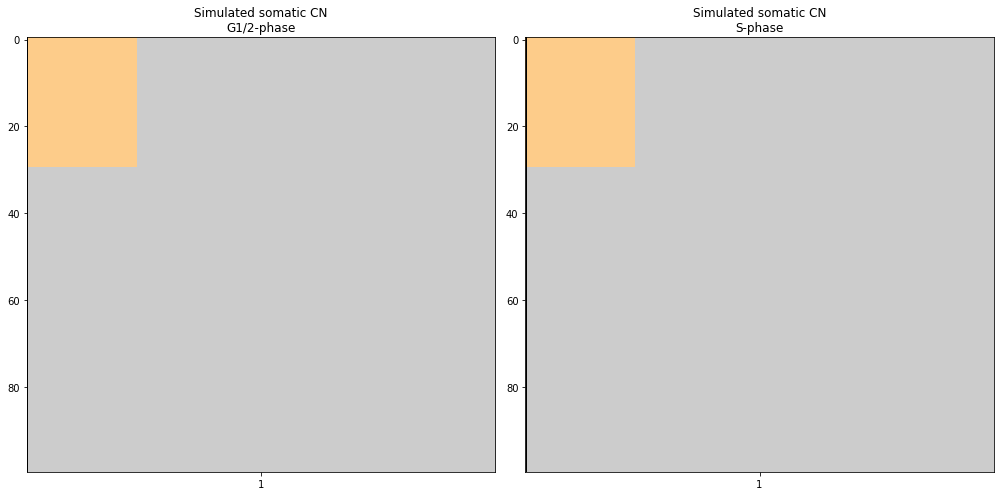

In [5]:
# plot the simulated true somatic CN states
plot_cn_states(cn_s, cn_g, clone_col='clone_id', cn_col='true_somatic_cn', title0='Simulated somatic CN\nG1/2-phase', title1='Simulated somatic CN\nS-phase')
plt.show()

### Simulate read counts given this set of true somatic CN states and a set of PERT parameters

In [6]:
num_reads = int(1e6 / 20) ## assume 1 million reads per cell, and we have are only simulating ~5% of the genome in chr1
clones = ['A', 'B']  # clone A has the CNA, clone B does not
rt_cols = ['mcf7rt', 'mcf7rt']  # both clones A and B follow the same MCF7 RepliSeq profile (i.e. no clone-specific RT bias)
lamb = 0.75  # negative binomial dispersion parameter
betas = [0.5, 0.0]  # gc bias terms: slope=0.5, intercept=0.0
a = 10.0  # replication stochasticity parameter alpha

cn_s, cn_g = pert_simulator(cn_s, cn_g, num_reads, rt_cols, clones, lamb, betas, a, gc_col='gc', input_cn_col='true_somatic_cn')
cn_s.head()

,chr,start,end,gc,mcf7rt,bin_size,cell_id,library_id,true_somatic_cn,clone_id,true_reads_norm,true_reads_raw,true_rep,true_p_rep,true_t,true_total_cn
0,1,1000000,1500000,0.598330,81.441980,500000,cell_0_s,ABCD,3.0,A,258,562.0,1.0,0.994065,0.512097,6.0
1,1,1500000,2000000,0.539496,79.131013,500000,cell_0_s,ABCD,3.0,A,243,530.0,1.0,0.991746,0.512097,6.0
2,1,2000000,2500000,0.594508,78.557313,500000,cell_0_s,ABCD,3.0,A,256,557.0,1.0,0.991042,0.512097,6.0
3,1,3000000,3500000,0.584570,70.388076,500000,cell_0_s,ABCD,3.0,A,233,507.0,1.0,0.971579,0.512097,6.0
4,1,4000000,4500000,0.482572,48.663092,500000,cell_0_s,ABCD,3.0,A,93,204.0,0.0,0.600709,0.512097,3.0


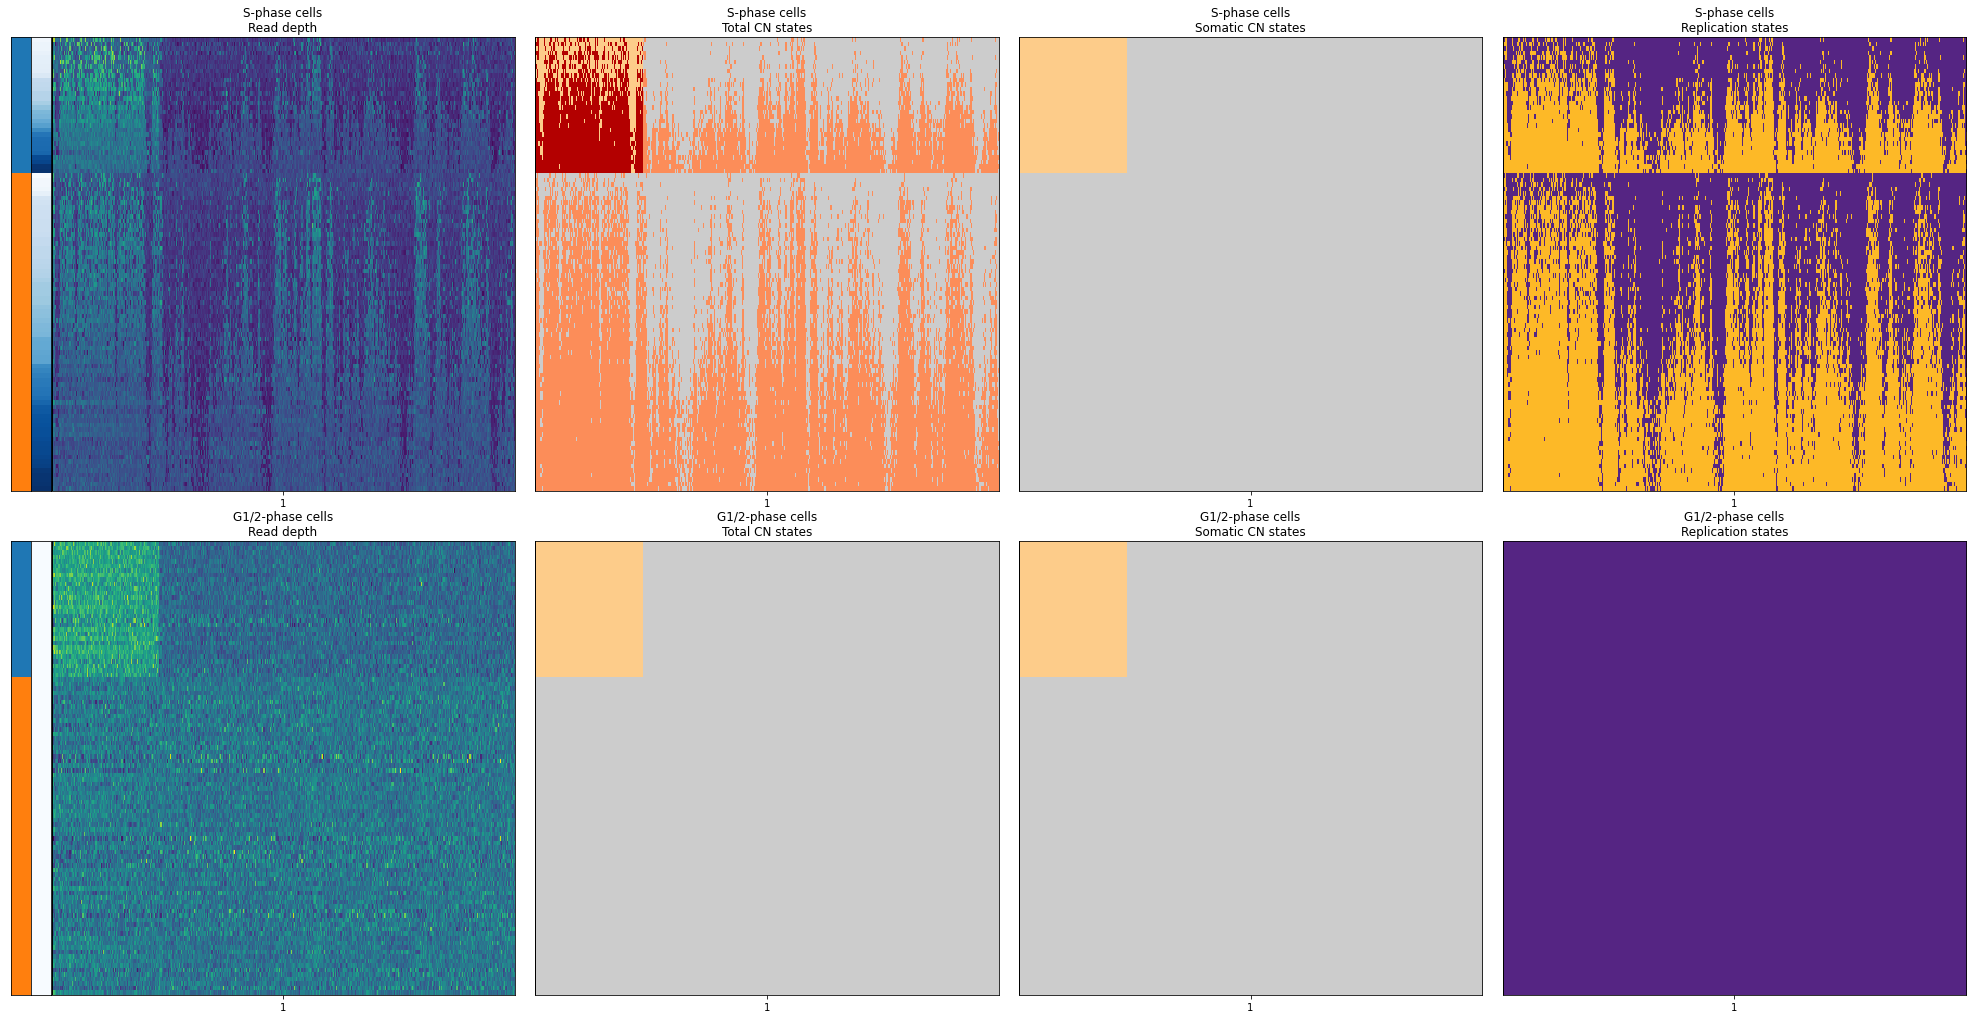

In [7]:
plot_model_results(
    cn_s, cn_g, clone_col='clone_id', second_sort_col='true_t', 
    input_cn_col='true_total_cn', output_cn_col='true_somatic_cn', 
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='Total CN states',
    output_cn_title='Somatic CN states', rep_title='Replication states'
)
plt.show()